# A Data Science Regression Case Study Project

A comprehensive roadmap towards approaching a data science regression project, covering all major steps - from exploratory data analysis and data preprocessing to hyperparameter tuning - to create the most effective predictive model. More specifically, the following steps are demonstrated:
* Exploratory Data Analysis (EDA)
* dataset splitting early on to avoid data leakage
* missing values imputation
* encoding (categorical -> numerical data)
* feature scaling, encoding, unskewing
* feature extraction
* automated hyperparameter tuning using GridSearchCV with pipelines and parameter grids

We will use the Student Performance dataset (https://archive.ics.uci.edu/dataset/320/student+performance) since it has various preprocessing needs.

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. In this study we will use the maths related data only.

Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from scipy.stats import shapiro, anderson, kstest, normaltest, jarque_bera, normaltest, boxcox, yeojohnson
from statsmodels.stats.diagnostic import lilliefors
from scipy.special import inv_boxcox
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA, FactorAnalysis
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load dataset
url = "students-mat.csv"
df = pd.read_csv(url)

## Exploratory Data Analysis

In [3]:
# print 5 first observations to start getting familiar with the dataset
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17.0,U,GT3,T,1.0,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15.0,U,LE3,T,1.0,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15.0,U,GT3,T,4.0,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16.0,U,GT3,T,3.0,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
# print column types
df.dtypes

school         object
sex            object
age           float64
address        object
famsize        object
Pstatus        object
Medu          float64
Fedu            int64
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime    float64
studytime     float64
failures        int64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel          int64
freetime        int64
goout           int64
Dalc            int64
Walc            int64
health          int64
absences        int64
G1              int64
G2              int64
G3              int64
dtype: object

In [5]:
df.shape

(395, 33)

In [6]:
# Missing values
missing_values = df.isnull().sum()
print("Missing Values per Column:")
missing_values

Missing Values per Column:


school         0
sex            0
age           28
address        0
famsize        2
Pstatus       11
Medu           2
Fedu           0
Mjob           4
Fjob           0
reason        10
guardian       0
traveltime     9
studytime      5
failures       0
schoolsup      0
famsup         0
paid           0
activities     7
nursery        0
higher         0
internet       0
romantic      17
famrel         0
freetime       0
goout          0
Dalc           0
Walc           0
health         0
absences       0
G1             0
G2             0
G3             0
dtype: int64

In [7]:
# Summary statistics for numerical features
print("Summary Statistics:")
df.describe()

Summary Statistics:


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,367.000000,393.000000,395.000000,386.000000,390.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.705722,2.753181,2.521519,1.448187,2.038462,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.250375,1.093882,1.088201,0.697796,0.842970,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,21.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


#### Target Variable Analysis (G3)

The dataset contains the final grade (G3) as the primary target variable. We can perform the following tasks as part of the EDA:

* Distribution of G3:
    * Plot a histogram or density plot to observe the grade distribution.
    * Check for normality, skewness and outliers.
* Bin G3 into categories:
    * Create categories like "Low," "Average," and "High" performance to analyze patterns.

Text(0, 0.5, 'Frequency')

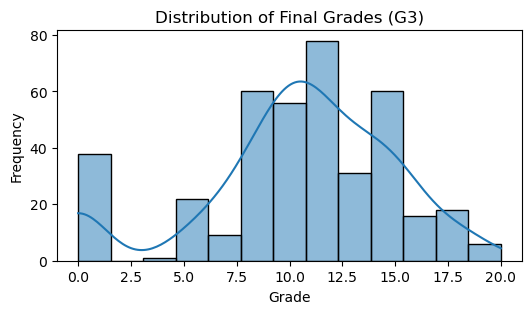

In [8]:
# Distribution of the target variable
fig,ax = plt.subplots(figsize=(6,3))
sns.histplot(df['G3'], kde=True)
ax.set_title("Distribution of Final Grades (G3)")
ax.set_xlabel("Grade")
ax.set_ylabel("Frequency")

The target variable does not seem to involve outliers. This visual observation can be also confirmed by the following boxplot:

<Axes: ylabel='G3'>

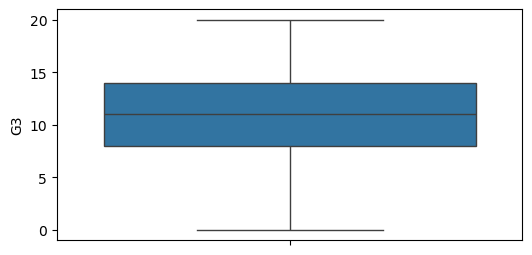

In [9]:
fig,ax = plt.subplots(figsize=(6,3))
sns.boxplot(data=df, y='G3')

The target variable can be said that it does not follow the normal distribution based on the output of the normality tests shown below. All of them are

In [10]:
def run_normality_tests(data):
    """
    Perform various normality tests (Shapiro-Wilk, Anderson-Darling, Kolmogorov-Smirnov, D'Agostino and Pearson, Jarque-Bera, and Lilliefors) on a given dataset.
    Choosing the Right Test:
        * For small sample sizes (< 50), the Shapiro-Wilk Test is recommended.
        * For larger samples, use the D’Agostino and Pearson’s Test or Jarque-Bera Test.
        * If you need critical values, use the Anderson-Darling Test.
        * Use the Kolmogorov-Smirnov Test or Lilliefors Test for additional validation, especially when comparing with a reference distribution.
    
    All tests compute a p-value. The p-value (probability value) is a statistical measure that helps you determine whether the observed data is consistent with a 
    null hypothesis. In the context of normality tests, the null hypothesis is usually: "The data follows a normal distribution."
    
    How to Interpret the p-value:
        * High p-value (>= 0.05): There is not enough evidence to reject the null hypothesis. This suggests that the data might follow a normal distribution.
        * Low p-value (< 0.05): The null hypothesis is rejected. This indicates that the data does not follow a normal distribution.
        
    In Practice
        * If a test returns a p-value of 0.03, it means there is a 3% probability that the data could have arisen under the assumption of a normal distribution. In this case, you would reject the null hypothesis (assuming a 5% significance threshold).
        * If a test returns a p-value of 0.2, it suggests there is no strong evidence against the data being normal.

    Caveats
        * A high p-value does not prove normality, it simply suggests that the data is not inconsistent with a normal distribution.
        * A low p-value indicates a deviation from normality but does not specify the nature of that deviation (e.g., skewness, kurtosis).

    Parameters:
        data (array-like): The dataset to test for normality.

    Returns:
        dict: A dictionary containing test results with the test name, statistic, p-value, and whether the data is considered normal at a 5% significance level.
    """
    results = {}

    # Shapiro-Wilk Test
    try:
        stat, p = shapiro(data)
        results['Shapiro-Wilk Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Shapiro-Wilk Test'] = {'Error': str(e)}

    # Anderson-Darling Test
    try:
        result = anderson(data, dist='norm')
        results['Anderson-Darling Test'] = {
            'Statistic': result.statistic,
            'Critical Values': result.critical_values,
            'Significance Levels': result.significance_level,
            'Normal': result.statistic < result.critical_values[2]  # At 5% level
        }
    except Exception as e:
        results['Anderson-Darling Test'] = {'Error': str(e)}

    # Kolmogorov-Smirnov Test
    try:
        standardized_data = (data - np.mean(data)) / np.std(data)
        stat, p = kstest(standardized_data, 'norm')
        results['Kolmogorov-Smirnov Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Kolmogorov-Smirnov Test'] = {'Error': str(e)}

    # D’Agostino and Pearson’s Test
    try:
        stat, p = normaltest(data)
        results['D’Agostino and Pearson’s Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['D’Agostino and Pearson’s Test'] = {'Error': str(e)}

    # Jarque-Bera Test
    try:
        stat, p = jarque_bera(data)
        results['Jarque-Bera Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Jarque-Bera Test'] = {'Error': str(e)}

    # Lilliefors Test
    try:
        stat, p = lilliefors(data)
        results['Lilliefors Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Lilliefors Test'] = {'Error': str(e)}

    return results

In [11]:
results = run_normality_tests(df['G3'])
for test, result in results.items():
    print(f"{test}: {result}")

Shapiro-Wilk Test: {'Statistic': 0.928729849872698, 'p-value': 8.835916843805374e-13, 'Normal': False}
Anderson-Darling Test: {'Statistic': 8.30320458141631, 'Critical Values': array([0.57 , 0.65 , 0.779, 0.909, 1.081]), 'Significance Levels': array([15. , 10. ,  5. ,  2.5,  1. ]), 'Normal': False}
Kolmogorov-Smirnov Test: {'Statistic': 0.134735987568745, 'p-value': 1.0269383080656354e-06, 'Normal': False}
D’Agostino and Pearson’s Test: {'Statistic': 32.05917094576832, 'p-value': 1.092545372561713e-07, 'Normal': False}
Jarque-Bera Test: {'Statistic': 37.48826984009276, 'p-value': 7.236451174084543e-09, 'Normal': False}
Lilliefors Test: {'Statistic': 0.1347816508803158, 'p-value': 0.0009999999999998899, 'Normal': False}


From the aforementioned resuts, **G3 deviates from normality**.

From the histogram and the kernel density estimate (KDE) curve shown above, we can say that the distribution appears to be fairly symmetric around its central peak, which is approximately 10-12. There are slight tails on both ends, but no extreme elongation on either side. The distribution is approximately symmetric, suggesting that the skewness value would be close to zero. However, the exact skewness value would need to be calculated. Below, we are using the .skew() function to reveal if the target variable is skewed:

* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
* If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately left-skewed or right-skewed respectively
* If the skewness is less than -1 or greater than 1, the data are highly left-skewed or right-skewed respectively

In [12]:
print('skewness:', df['G3'].skew())

skewness: -0.7326723530443435


As shown above, the **target variable is moderately left-skewed**, therefore unskewing techniques such as Log, Sqrt, Box-Cox and Yeo-Johnson can be applied. Only the latter technique can be used if the variable to be transformed contains both negative, zero and positive values.

#### Categorical Features Analysis

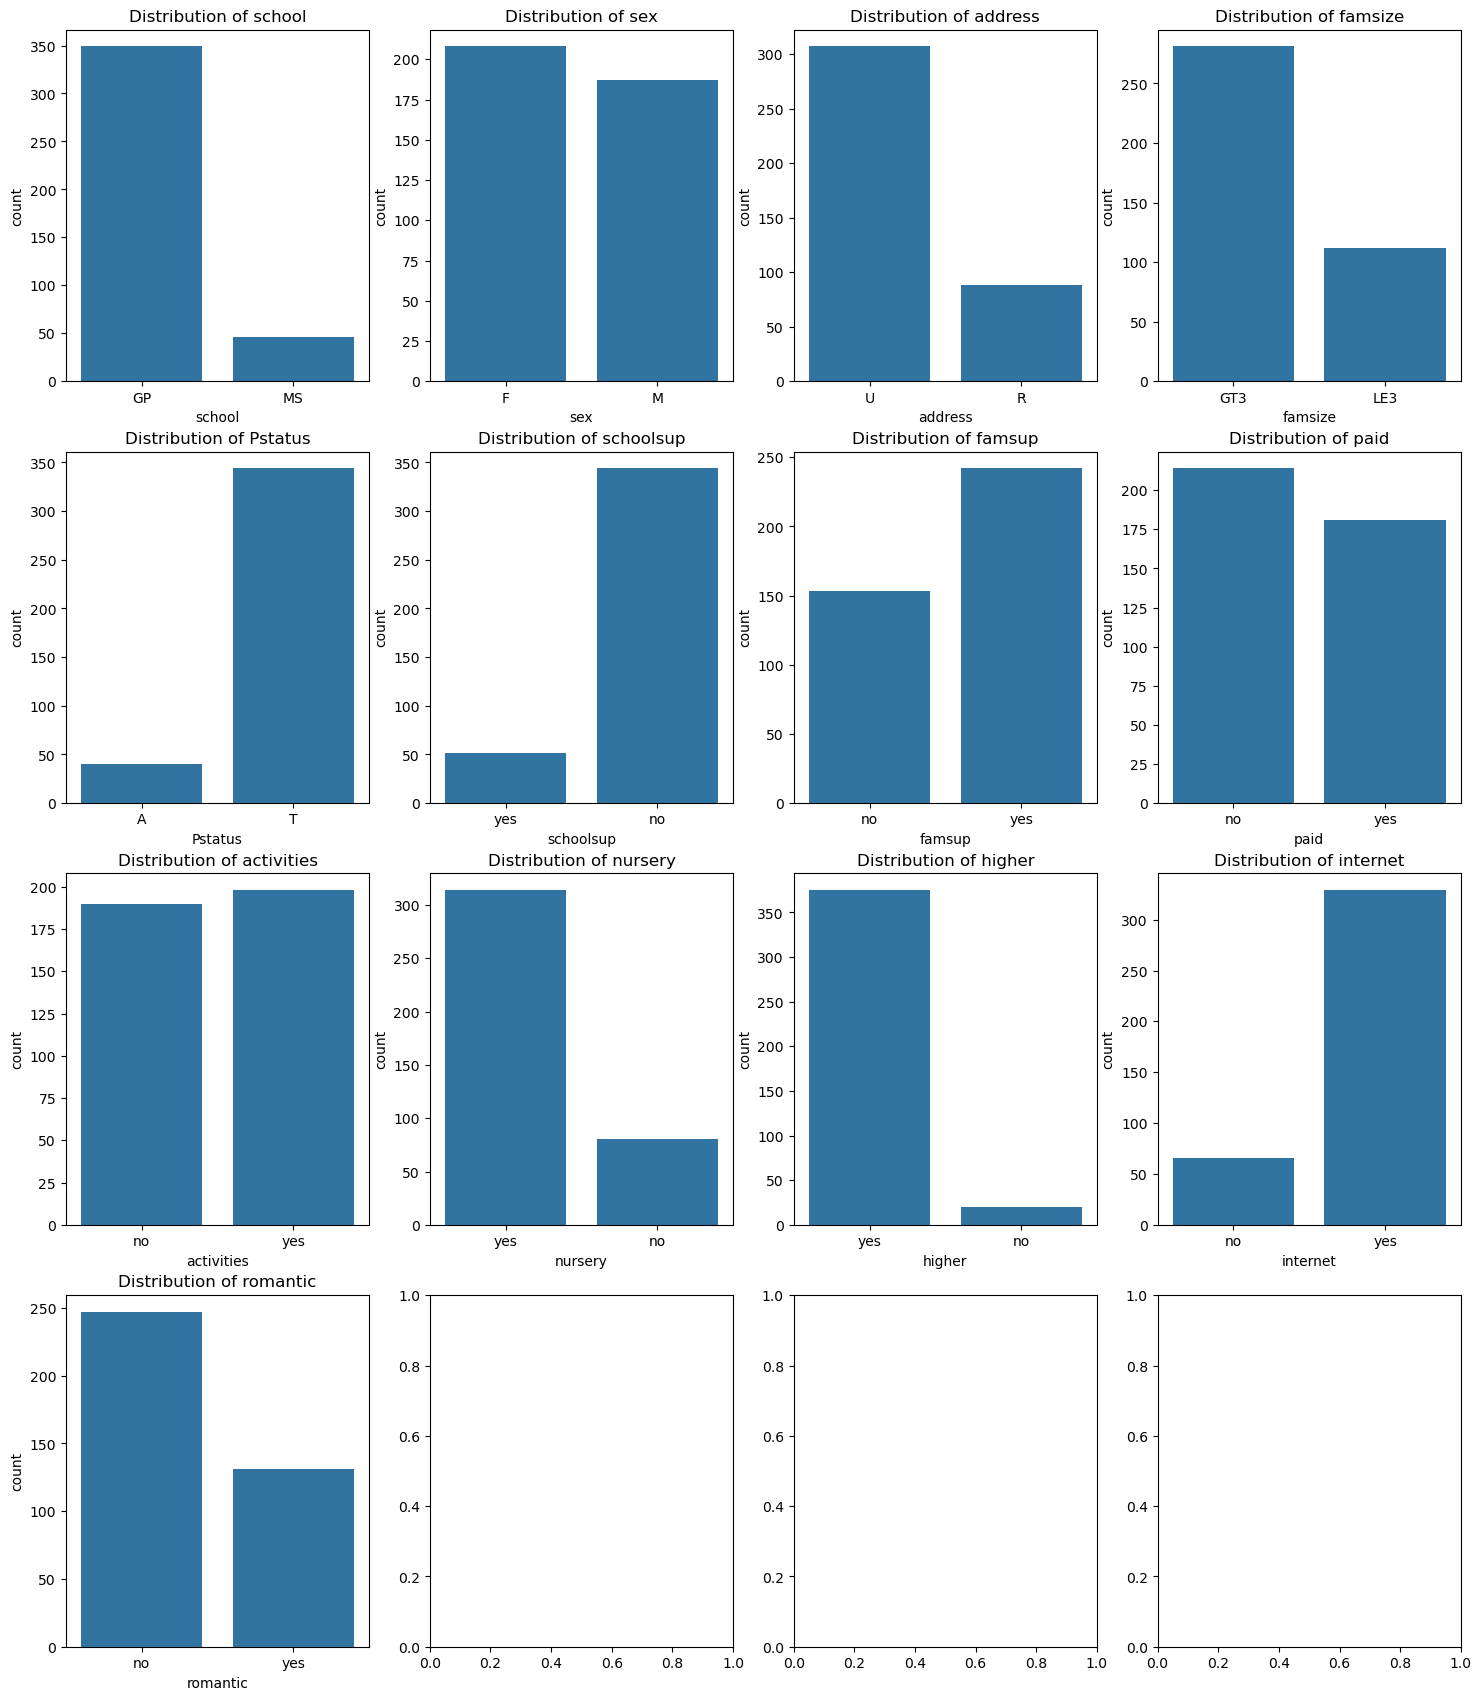

In [13]:
categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
nrows, ncols = 4,4
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in categorical_features:
    sns.countplot(x=feature, data=df, ax=axs[i,j])
    axs[i,j].set_title(f"Distribution of {feature}")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

The bar plots shown above depict the distributions of several categorical variables in the dataset. Here are observations and insights for each feature:

1. School (school)
    * GP (Gabriel Pereira) has significantly more students than MS (Mousinho da Silveira).
    * This imbalance might affect analyses involving the school variable. Stratified sampling might be necessary for fair comparisons.
2. Sex (sex)
    * The distribution of males (M) and females (F) is relatively balanced, with a slight majority of female students.
    * This balance is good for avoiding gender-related biases in analysis or modeling.
3. Address (address)
    * A large majority of students live in urban (U) areas compared to rural (R) areas.
    * The dataset's findings may reflect urban education trends more than rural ones.
4. Family Size (famsize)
    * Students with families greater than 3 members (GT3) are more frequent than those with families of 3 or fewer (LE3).
    * Family size could be an interesting factor to explore when analyzing its impact on student performance.
5. Parental Status (Pstatus)
    * Most students' parents are living together (A), while a smaller proportion have separated parents (T).
    * This variable might be useful for exploring how family dynamics impact academic performance.
6. School Support (schoolsup)
    * Most students do not receive additional school support (no), but a noticeable minority does (yes).
    * Investigating the performance difference between students with and without school support could be valuable.
7. Family Support (famsup)
    * Similar to schoolsup, most students do not receive family support (no), though a significant proportion does (yes).
    * A comparison between students with and without family support could yield insights into its importance for academic outcomes.
8. Paid Extra Classes (paid)
    * The distribution is relatively balanced, but slightly more students do not take paid extra classes (no).
    * Analysis could focus on whether paid classes lead to better academic performance (e.g., higher G3 scores).
9. Extracurricular Activities (activities)
    * The number of students participating in extracurricular activities (yes) is roughly equal to those not participating (no).
    * This variable can be useful for understanding the role of extracurricular engagement on academic outcomes.
10. Nursery School Attendance (nursery)
    * The majority of students attended nursery school (yes), while a minority did not (no).
    * It could be interesting to analyze whether early education correlates with better grades or other variables.
11. Higher Education Intentions (higher)
    * Almost all students aim for higher education (yes), with very few not planning to continue education (no).
    * This high proportion could reduce variability, making it less impactful as a predictive feature.
12. Internet Access (internet)
    * Most students have internet access at home (yes), while a smaller group does not (no).
    * Exploring the relationship between internet access and academic performance could provide insights, particularly in terms of access to learning resources.
13. Romantic Relationship (romantic)
    * A majority of students are not in a romantic relationship (no), while a smaller proportion are (yes).
    * This could be explored to determine if romantic relationships impact academic performance or study habits.

*General Observations:*

* Imbalanced Features: Some features (e.g., higher, nursery, address, Pstatus) are highly imbalanced, which may reduce their usefulness for certain analyses or predictive modeling.
* Visualization Options: Grouped bar plots or stacked plots could be used to visualize interactions between categorical features (e.g., schoolsup vs famsup).
* Insights from Interactions: Exploring the relationships between these categorical features and the target variable (G3) could reveal interesting patterns. In order to elaborate more on this task, we can use the numerical version of the target variable or provide a categorization of students into dinstict categories (using binning on the G3 -- see below) thus making it easier to spot broad trends or patterns.

#### Numerical Features Analysis

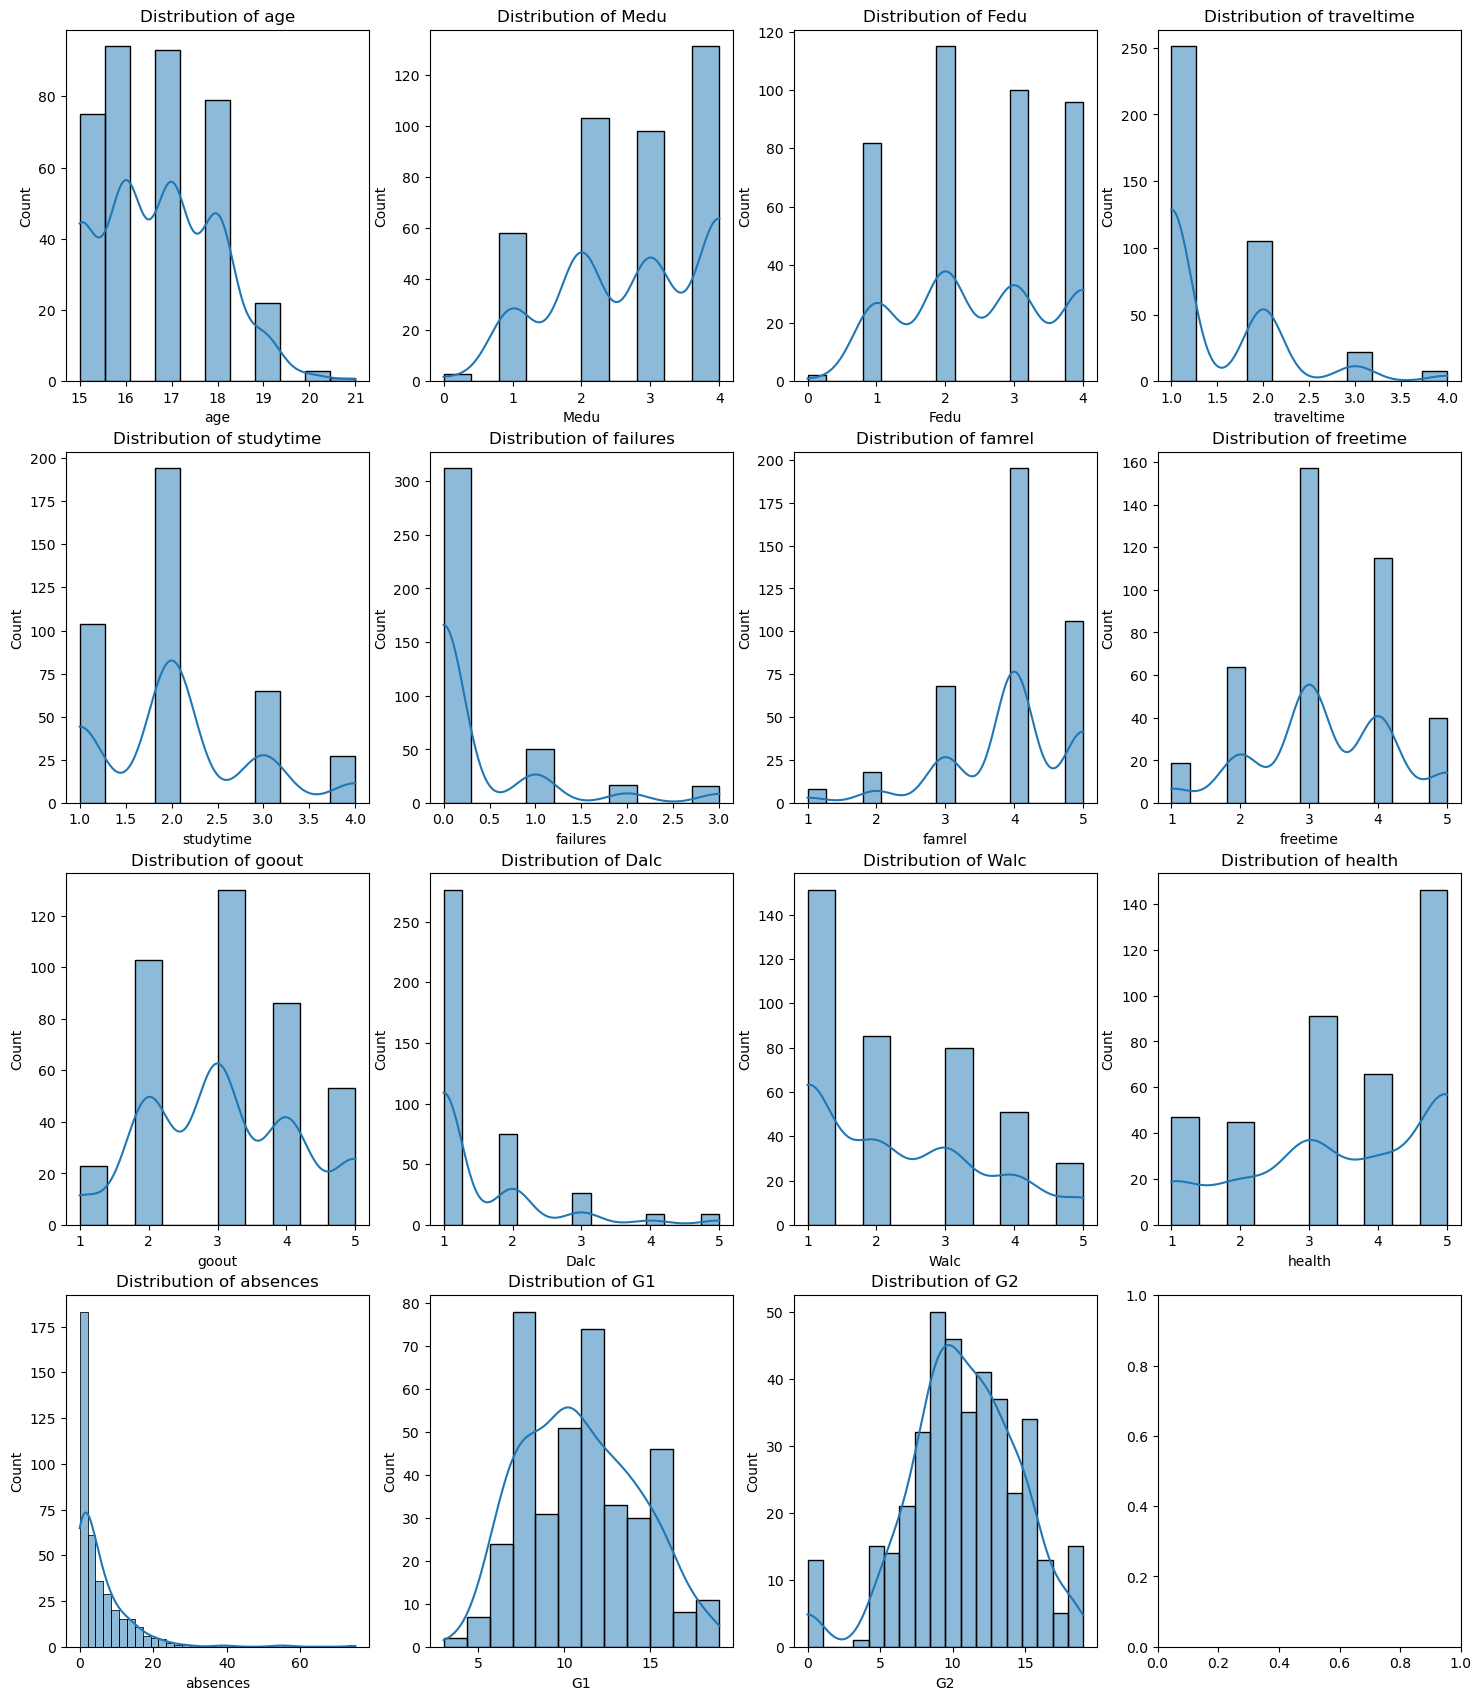

In [14]:
numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']
nrows,ncols = 4,4
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in numerical_features:
    sns.histplot(df[feature], kde=True, ax=axs[i,j])
    axs[i,j].set_title(f"Distribution of {feature}")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

Age and absences seem to be right skewed, while G1 and G2 are close to normal distribution. We can confirm these observations by using statistical measures as shown below:

In [15]:
print('Age skewness:', df['age'].skew())
print('Absences skewness:', df['absences'].skew())
print('Normality tests for G1\n======================')
results = run_normality_tests(df['G1'])
for test, result in results.items():
    print(f"{test}: {result}")
print('Normality tests for G2\n======================')
results = run_normality_tests(df['G2'])
for test, result in results.items():
    print(f"{test}: {result}")

Age skewness: 0.3099070931477198
Absences skewness: 3.6715789504758862
Normality tests for G1
Shapiro-Wilk Test: {'Statistic': 0.9749134463536321, 'p-value': 2.4541585453322648e-06, 'Normal': False}
Anderson-Darling Test: {'Statistic': 3.2267436964076524, 'Critical Values': array([0.57 , 0.65 , 0.779, 0.909, 1.081]), 'Significance Levels': array([15. , 10. ,  5. ,  2.5,  1. ]), 'Normal': False}
Kolmogorov-Smirnov Test: {'Statistic': 0.09662942363084004, 'p-value': 0.0011602978195641197, 'Normal': False}
D’Agostino and Pearson’s Test: {'Statistic': 22.612048290638576, 'p-value': 1.2298612026597037e-05, 'Normal': False}
Jarque-Bera Test: {'Statistic': 11.852351204527706, 'p-value': 0.002668668547586327, 'Normal': False}
Lilliefors Test: {'Statistic': 0.09649598812059312, 'p-value': 0.0009999999999998899, 'Normal': False}
Normality tests for G2
Shapiro-Wilk Test: {'Statistic': 0.9691414513461054, 'p-value': 2.083959796331057e-07, 'Normal': False}
Anderson-Darling Test: {'Statistic': 2.527

Based on the results, age feature is moderately right skewed while absences feature is highly right skewed. We can apply unskewing transformations (log, sqrt, Box-Cox, Yeo-Johnson) when experimenting with machine learning modelling.

G1 and G2 do not follow the normal distribution based on the normality tests. Since the values are on a different scale compared with the rest features, we can apply scaling *if we intend to use distance-based machine learning for predictive modelling*. Standard scaler, robust scaler, min max scaler can be used. Standard scaler is more appropriate when feature is approximately normal. Robust scaler is more applicable when feature has significant outliers. Max-min scaler is more appropriate when feature values need to be scaled within a specific range (this is usually needed in neural netwrorks.

The rest features have discrete numerical values, with low spread. Whether or not to transform such features depends on the context of the problem, the machine learning algorithm being used, and the role of the feature in your analysis. Here's a detailed explanation:

1. When Transformation is NOT Necessary
    * Tree-Based Models (e.g., Decision Trees, Random Forest, XGBoost): These models are invariant to scaling because they split data based on thresholds. Transforming a low-spread numerical feature (like 1-6) will not affect their performance.
    * Low Variability and No Skew: If the distribution is already uniform or balanced, and there's no skew, scaling is usually not required.
    * Feature Represents Ordinal Categories: If the feature represents an ordinal variable (e.g., levels like 1=low, 2=medium, 3=high), it already carries meaningful rank information. Scaling or normalizing may distort this interpretation.
2. When Transformation Might Be Necessary
    * Distance-Based Models (e.g., K-Nearest Neighbors, K-Means, SVMs): These models calculate distances between data points. A feature with a low spread might have less influence compared to other features with larger spreads. Scaling ensures all features are treated equally in terms of their contribution to distance metrics.
    * Gradient-Based Models (e.g., Neural Networks, Logistic Regression): Features with low spread may still need scaling (e.g., MinMaxScaler or StandardScaler) to improve optimization and training stability.
    * If Combined with Other Scaled Features: If other numerical features are scaled, it’s usually a good idea to scale this feature too, to maintain consistency.
    * If the Feature is Highly Skewed: Even low-spread features can exhibit skewness (e.g., a highly imbalanced frequency distribution). Applying transformations like log scaling or normalization can help.

#### Exploring relationships between features and the target variable (G3)

#### - Keep the target variable as continuous numerical variable: This approach is more precise and is better suited for statistical comparisons and detailed analyses.

1. Using plots: Visualize the distribution of G3 for each category of a categorical variable or statistical measures (mean, std, median) of G3 for each category of a categorical variable.

Text(0.5, 1.0, 'G3 Distribution by School')

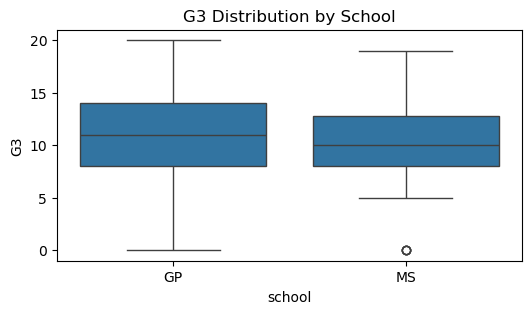

In [16]:
# Boxplots: Visualize the distribution of G3 for each category of a categorical variable.
fig,ax = plt.subplots(figsize=(6,3))
sns.boxplot(x='school', y='G3', data=df)
ax.set_title("G3 Distribution by School")

Text(0.5, 1.0, 'G3 median and std by Free Time')

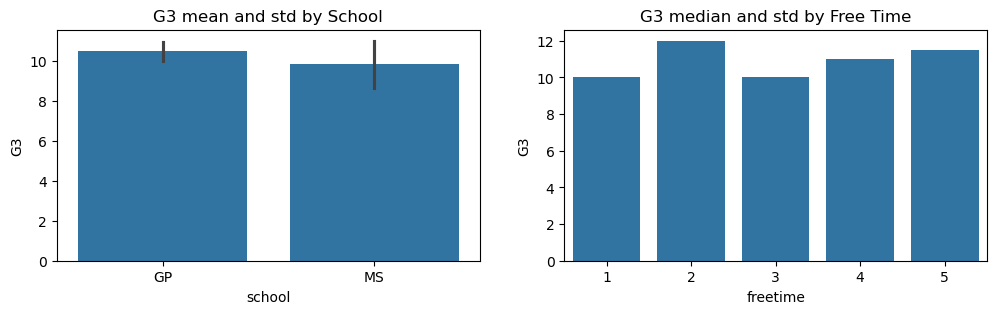

In [17]:
# Barplots: Visualize statistical measures (mean, std, median) of G3 for each category of a categorical variable.
fig, axs = plt.subplots(1, 2, figsize=(12,3))
sns.barplot(y='G3', x='school', data=df, ax=axs[0])
axs[0].set_title("G3 mean and std by School")

sns.barplot(y='G3', x='freetime', data=df, estimator='median', errorbar=None, ax=axs[1])
axs[1].set_title("G3 median and std by Free Time")

2. Using Group Statistics: Compute summary statistics like mean, median, and standard deviation for G3 across categories.

In [18]:
df.groupby('school')['G3'].agg(['mean', 'std', 'median'])

,mean,std,median
school,,,
GP,10.489971,4.625397,11.0
MS,9.847826,4.237229,10.0


#### - Convert target variable into categorical (e.g., Low, Average, High) using binning: This approach simplifies the analysis, making it easier to spot broad trends or patterns.

   G3 G3_category
0   6         Low
1   6         Low
2  10         Low
3  15     Average
4  10         Low
5  15     Average
6  11     Average
7   6         Low
8  19        High
9  15     Average


Text(0, 0.5, 'Count')

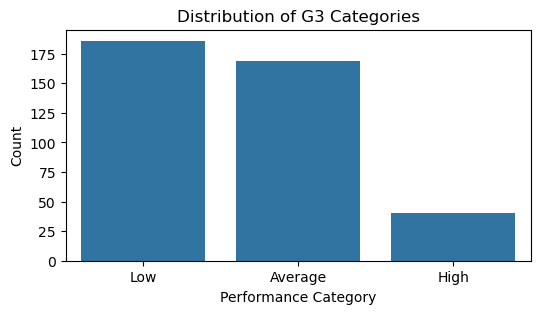

In [19]:
# Define bins and labels
bins = [0, 10, 15, 20]  # Define bin edges
labels = ['Low', 'Average', 'High']  # Define category labels

# Binning G3
df['G3_category'] = pd.cut(df['G3'], bins=bins, labels=labels, include_lowest=True)

# Display the new column
print(df[['G3', 'G3_category']].head(10))

# Visualize the distribution of categories
fig,ax = plt.subplots(figsize=(6,3))
sns.countplot(x='G3_category', data=df)
ax.set_title("Distribution of G3 Categories")
ax.set_xlabel("Performance Category")
ax.set_ylabel("Count")

The newly binned feature G3_category can be utilized in several ways depending on your analysis goals. Here are some ideas:

1. **Analyzing Categorical Performance Trends:** You can now group and analyze the data based on the performance categories (Low, Average, High).

In [20]:
# Group by the new category and calculate mean of other variables
grouped_data = df.groupby('G3_category', observed=True).mean(numeric_only=True)
grouped_data

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
G3_category,,,,,,,,,,,,,,,,
Low,16.886905,2.565217,2.322581,1.554945,1.950820,0.591398,3.956989,3.236559,3.290323,1.548387,2.467742,3.569892,6.188172,8.258065,7.698925,6.774194
Average,16.583851,2.822485,2.674556,1.379518,2.095808,0.124260,3.899408,3.207101,2.946746,1.455621,2.189349,3.597633,5.514793,12.532544,12.615385,12.810651
High,16.421053,3.325000,2.800000,1.236842,2.200000,0.025000,4.075000,3.350000,2.950000,1.275000,1.900000,3.300000,4.300000,16.375000,16.700000,17.225000


Text(0, 0.5, 'Travel Time')

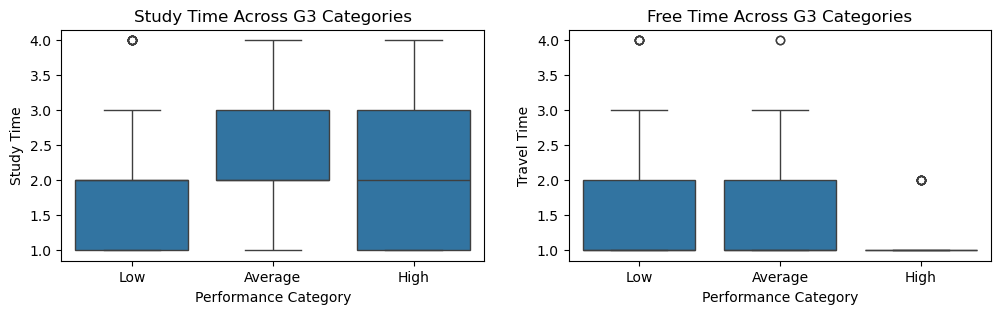

In [21]:
# Visualize study time across G3 categories
fig, axs = plt.subplots(1,2, figsize=(12,3))
sns.boxplot(x='G3_category', y='studytime', data=df, ax=axs[0])
axs[0].set_title("Study Time Across G3 Categories")
axs[0].set_xlabel("Performance Category")
axs[0].set_ylabel("Study Time")

sns.boxplot(x='G3_category', y='traveltime', data=df, ax=axs[1])
axs[1].set_title("Free Time Across G3 Categories")
axs[1].set_xlabel("Performance Category")
axs[1].set_ylabel("Travel Time")

2. Feature Interaction

You can compare G3_category with other variables to find patterns and relationships.

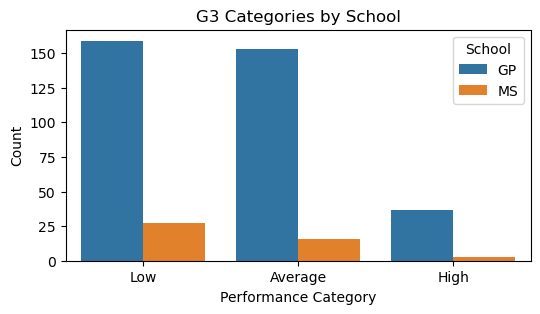

In [22]:
# Comparing with Categorical Variables
# Example: Compare G3_category with 'school'
fig,ax = plt.subplots(figsize=(6,3))
sns.countplot(x='G3_category', hue='school', data=df)
ax.set_title("G3 Categories by School")
ax.set_xlabel("Performance Category")
ax.set_ylabel("Count")
ax.legend(title="School")

Text(0, 0.5, 'Average Absences')

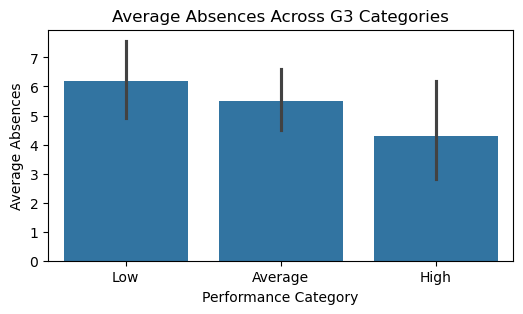

In [23]:
# Comparing with Numerical Variables
# Example: Compare absences across performance categories
fig,ax = plt.subplots(figsize=(6,3))
sns.barplot(x='G3_category', y='absences', data=df)
ax.set_title("Average Absences Across G3 Categories")
ax.set_xlabel("Performance Category")
ax.set_ylabel("Average Absences")

3. Use in Machine Learning Models: You can use G3_category as a target variable instead of the continuous G3 for classification tasks.

We wil use this approach later.

#### Example 1: Study Habits and Lifestyle on the target variable

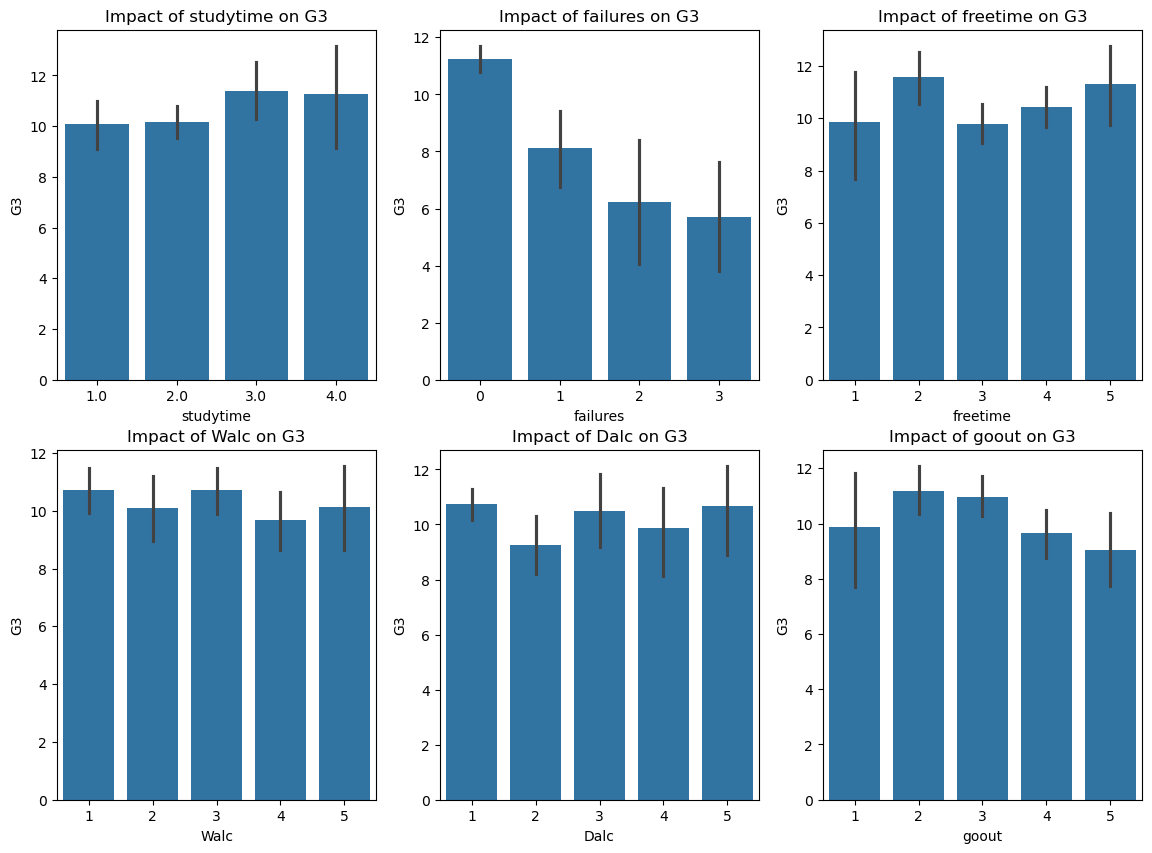

In [24]:
study_features = ['studytime', 'failures', 'freetime', 'Walc', 'Dalc', 'goout']
nrows,ncols = 2,3
fig, axs = plt.subplots(nrows, ncols, figsize=(14,10))
i,j = 0,0
for feature in study_features:
    sns.barplot(x=feature, y='G3', data=df, ax=axs[i,j])
    axs[i,j].set_title(f"Impact of {feature} on G3")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

#### Example 2: Study Schooling and Family Influence on the target variable

Text(0.5, 1.0, 'G3 by Family Support')

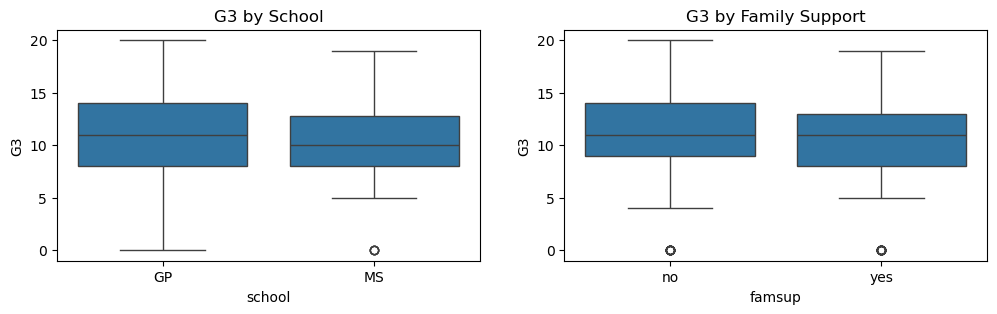

In [25]:
fig,axs = plt.subplots(1, 2, figsize=(12,3))
sns.boxplot(x='school', y='G3', data=df, ax=axs[0])
axs[0].set_title("G3 by School")

sns.boxplot(x='famsup', y='G3', data=df, ax=axs[1])
axs[1].set_title("G3 by Family Support")

#### Example 3: Study Absences Influence on the target variable

Text(0.5, 1.0, 'Absences vs G3')

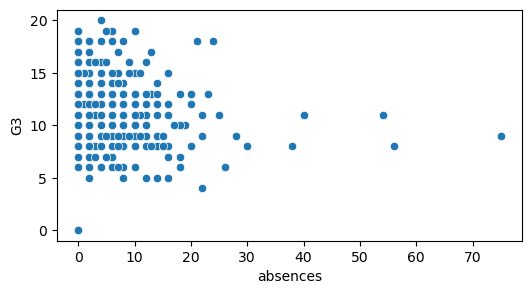

In [26]:
fig,axs = plt.subplots(figsize=(6,3))
sns.scatterplot(x='absences', y='G3', data=df)
ax.set_title("Absences vs G3")

#### Correlation Matrix

Correlation matrix a valuable tool for revealing the linear relationships between numerical variables. A correlation matrix displays the pairwise correlation coefficients between numerical features a dataset.

Text(0.5, 1.0, 'Correlation Matrix')

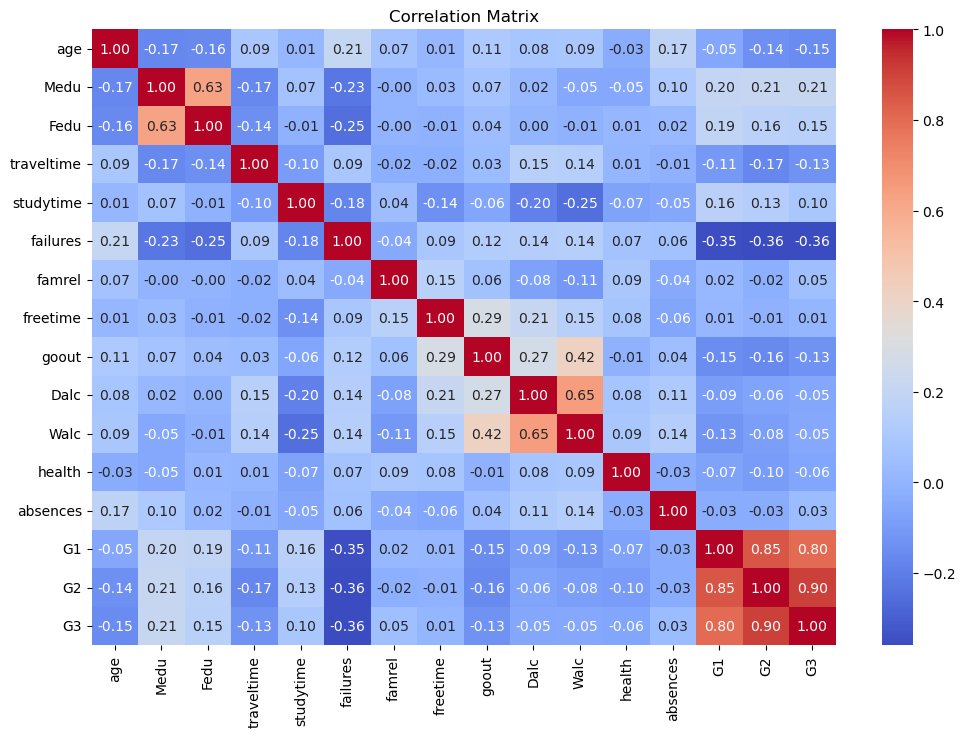

In [27]:
corr_matrix = df.corr(numeric_only=True)
fig,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
ax.set_title("Correlation Matrix")

From the correlation matrix heatmap provided, here are some key observations:

1. Correlation of G3 (Final Grade)
    * G3 has strong positive correlations with:
        - G1 (First Period Grade): 0.80
        - G2 (Second Period Grade): 0.90
        - This suggests that the performance in earlier periods strongly predicts the final grade.
    * G3 has moderate negative correlation with:
        - failures (Number of Past Failures): -0.36
        - This indicates that students with more past failures tend to have lower final grades.
2. Correlation Between Other Features
    * Medu (Mother's Education) and Fedu (Father's Education):
        - Strong positive correlation (0.63) suggests that parental education levels are related.
        - Walc (Weekend Alcohol Consumption) and Dalc (Workday Alcohol Consumption): Strong positive correlation (0.65) indicates that students who consume alcohol on workdays tend to consume it on weekends as well.
        - G1 and G2: High positive correlation (0.85) suggests strong consistency in student performance between the first two periods.
3. Weak or No Correlation
    * Many features, such as health, famrel (Family Relationship Quality), and freetime, have very low or negligible correlations with grades (close to 0).
        - These features may not contribute significantly to predicting G3 and could be less relevant for modeling.
4. Multicollinearity
    * High correlations between G1, G2, and G3 suggest potential multicollinearity if these features are included in a regression model.
        - Consider using only one of these features or techniques like principal component analysis (PCA) to address this.
5. Interesting Patterns
    * absences: Weak correlation with G3 (0.03) indicates that the number of absences may not significantly affect grades.
    * failures: Negative correlation with grades suggests that reducing the number of failures could be a key to better performance.
    * Dalc and Walc: Negligible or weak correlations with grades (0.05) indicate that alcohol consumption may not have a strong direct impact on academic performance.

What to do next:

    * Highly correlated features such as Medu and Fedu can be dropped since they may contain redundant information. Currenty, we will not drop them though.

### Split dataset

In [28]:
# Split features and target (keep G3 as target variable to solve a regression problem; G3_category can be used to solve a classification problem)
X = df.drop(['G3', 'G3_category'] , axis=1)
y = df['G3']

In [29]:
# Split the data into training and test sets before scaling, encoding to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Apply PowerTransformer with Yeo-Johnson method on the target variable
# We could apply Box-Cox if all values were positive
yj = PowerTransformer(method='yeo-johnson')

# fit_transform() and transform() need 2D input data but y_train and Y_test are 1D Pandas Series. So, convert them to DataFrames with a single column.to_frame()
y_train_yj = yj.fit_transform(y_train.to_frame())  # Fit and transform training data
y_test_yj = yj.transform(y_test.to_frame())  # Transform test data

# alternative solution: y_train and y_test can be cnverted to 2D NumPy arrays using column.reshape()
# y_train_yj = yj.fit_transform(y_train.values.reshape(-1, 1))  # Fit and transform training data
# y_test_yj = yj.transform(y_test.values.reshape(-1, 1))  # Transform test data

# Convert the results back to pandas Series with the original index
y_train_yj = pd.Series(y_train_yj.flatten(), index=y_train.index, name='y_train_yj')
y_test_yj = pd.Series(y_test_yj.flatten(), index=y_test.index, name='y_test_yj')

## Data Preprocessing and hyperparameter tuning

In a data science project, particularly after completing exploratory data analysis (EDA) and data splitting, there are basically 2 approaches to follow:

#### Approach A: Create Different Dataset Versions (based on different pre-processing strategies) and Evaluate Multiple Estimators

Process: 
* Perform imputation, scaling, encoding and transformations on the original dataset to create multiple versions of the dataset. 
* Apply various estimators (regressors or classifiers depending on the target variable) with default hyperparameters on each version of the dataset. 
* Use cross-validation to evaluate performance and identify the best-performing models.

Advantages:
* Model Diversity: This approach allows you to explore how different preprocessing strategies (scaling and encoding) impact model performance across various estimators.
* Insightful Results: By evaluating multiple estimators on different dataset versions, you gain insights into which preprocessing methods work best with specific models.
* Initial Benchmarking: It helps identify a few strong candidates for further hyperparameter tuning without getting bogged down in complex grid searches early on.

Disadvantages:
* Time-Consuming: This approach can be computationally expensive and time-consuming, especially with a large number of dataset versions and models.
* Overhead: Managing and comparing multiple datasets can become cumbersome.

#### Approach B: Use Pipelines (to apply different pre-processing strategies) and GridSearchCV for Hyperparameter Tuning

Process:
* Define a pipeline that incorporates preprocessing steps (imputation, scaling, encoding, transformations) and estimators.
* Perform GridSearchCV to tune hyperparameters (use a grid of different combination of hyperparameters) while evaluating different preprocessing techniques in the pipeline.

Advantages:
* Efficiency: This approach is more streamlined and efficient, allowing you to optimize hyperparameters and preprocessing steps in a single step.
* Integrated Approach: By using pipelines, you ensure that the same preprocessing steps are applied consistently during both training and evaluation, reducing the risk of data leakage.

Disadvantages:
* Limited Exploration: You may miss out on valuable insights that come from exploring a wider range of models and preprocessing strategies manually (intermediate results are not apparent).
* Complexity: Setting up pipelines and managing the hyperparameter search space can become complex, particularly if there are many preprocessing options to consider.

#### Recommended Approach

In practice, a hybrid approach often works best:

* Start with Approach A: Conduct initial experiments with different preprocessing strategies and a larger variety of models using default hyperparameters to understand which combinations yield the best performance.
* Narrow Down: Based on the initial findings, narrow down to the top 2-3 models and their best-performing preprocessing methods.
* Then Move to Approach B: Utilize GridSearchCV with pipelines for these selected models and preprocessors to fine-tune hyperparameters.

This combined strategy allows you to benefit from both broad exploration and focused optimization, leading to more robust model development and potentially better performance.

#### APPROACH A

##### *Dataset V1*
1. Apply simple imputer with mean strategy on numerical features
2. Apply simple imputer with most frequent strategy and ordinal encoding on categorical features

In [31]:
X_train_V_1 = X_train.copy()
X_test_V_1 = X_test.copy()

# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Apply simple imputer with mean strategy on numerical features
si1 = SimpleImputer(strategy='mean')
# fit (train) imputer on the training dataset
si1.fit(X_train_V_1[num_features])
# apply imputation on both training and test datasets
X_train_V_1[num_features] = si1.transform(X_train_V_1[num_features])
X_test_V_1[num_features] = si1.transform(X_test_V_1[num_features])

# ALTERNATIVELY: you could fit and transform training data at the same time and then transform test data separately
#X_train_V_1[num_features] = si1.fit_transform(X_train_V_1[num_features])
#X_test_V_1[num_features] = si1.transform(X_test_V_1[num_features])

# Apply simple imputer with most_frequent strategy on categorical features
si2 = SimpleImputer(strategy='most_frequent')
si2.fit(X_train_V_1[cat_features])
X_train_V_1[cat_features] = si2.transform(X_train_V_1[cat_features])
X_test_V_1[cat_features] = si2.transform(X_test_V_1[cat_features])

# Apply ordinal encoding on categorical features
ordinal_encoder = OrdinalEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode unseen categories with -1
                                )
X_train_V_1[cat_features] = ordinal_encoder.fit_transform(X_train_V_1[cat_features])
X_test_V_1[cat_features] = ordinal_encoder.transform(X_test_V_1[cat_features])

#print(X_train_V_1)
#print(X_test_V_1)

##### Investigate feature elimination (feature selection / feature extraction) techniques

Since the number of features is relatively high, we can inverstigate whether feature selection and extraction can provide smaller feature sets which can reduce (a) computational costs during the training process of predictive modelling techniques as well as (b) reduce noise by discarding irrelevant or redundant features.

###### Feature Selection

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.6s finished

[2024-12-21 17:20:45] Features: 1/15 -- score: 0.817115432024002[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    7.8s finished

[2024-12-21 17:20:53] Features: 2/15 -- score: 0.860634183883667[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.0s finished

[2024-12-21 17:21:01] Features: 3/15 -- score: 0.8697828352451324[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    6.8s finished

[2024-12-21 17:21:08] Features: 4/15 -- score: 0.9112393438816071[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    7.2s finished

[2

best combination (ACC: 0.931): (2, 5, 13, 16, 18, 22, 23, 29, 31)

all subsets:
 {1: {'feature_idx': (31,), 'cv_scores': array([0.77579939, 0.86253583, 0.84173697, 0.8130424 , 0.88349551,
       0.8808679 , 0.87218249, 0.69840753, 0.73705035, 0.80603594]), 'avg_score': 0.817115432024002, 'feature_names': ('G2',)}, 2: {'feature_idx': (29, 31), 'cv_scores': array([0.90499926, 0.93289387, 0.88985217, 0.89161789, 0.8707273 ,
       0.87871844, 0.89699674, 0.7119745 , 0.79670703, 0.83185464]), 'avg_score': 0.860634183883667, 'feature_names': ('absences', 'G2')}, 3: {'feature_idx': (2, 29, 31), 'cv_scores': array([0.87962115, 0.88843262, 0.92747635, 0.80342031, 0.8078413 ,
       0.88313007, 0.92506194, 0.85417998, 0.8321954 , 0.89646924]), 'avg_score': 0.8697828352451324, 'feature_names': ('age', 'absences', 'G2')}, 4: {'feature_idx': (2, 18, 29, 31), 'cv_scores': array([0.9549005 , 0.8153463 , 0.90815669, 0.76249123, 0.91165912,
       0.93722373, 0.96148574, 0.94771677, 0.96696621, 0.9464

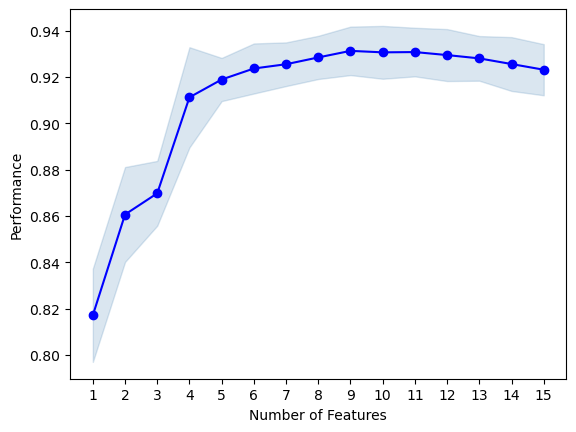

In [32]:
xgb = XGBRegressor()

# Sequential Forward Selection
sfs = SFS(xgb, 
           k_features=(5,15), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=10,
           n_jobs=-1)
           
sfs = sfs.fit(X_train_V_1, y_train)

print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
print('all subsets:\n', sfs.subsets_)
plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.show()

Based on the previous feature selection analysis, there is a smaleler featureset which achieves the highest performance (r2  score).
Therefore, it is worth creating another dataset consisting of the best performing features.

##### *Dataset V2 (the "best performing" selected features from V1)*

1. Apply simple imputer with mean strategy on numerical features
2. Apply simple imputer with most frequent strategy and ordinal encoding on categorical features
3. Sequential feature selection

In [33]:
#X_train_V_2 = sfs.transform(X_train_V_1) # this returns a numpy 2D array, not a pandas dataframe
X_train_V_2 = X_train_V_1.iloc[:, list(sfs.k_feature_idx_)]
X_test_V_2 = X_test_V_1.iloc[:, list(sfs.k_feature_idx_)]

###### Feature Extraction

Beyond feature selection, we can explore feature extraction using PCA. However, PCA is suitable for continuous numerical features but not appropriate for discrete numerical features. Since our dataset contains both numerical types, we will skip this step.

##### *Dataset V3 (the same as V1 but with unskewing on age and absences)*

1. Apply simple imputer with mean strategy on numerical features
2. Apply yeo johnson (unskewing) on age and absences
3. Apply simple imputer with most frequent strategy and ordinal encoding on categorical features

In [34]:
X_train_V_3 = X_train_V_1.copy()
X_test_V_3 = X_test_V_1.copy()

# Initialize the PowerTransformer with Yeo-Johnson method
# We could apply Box-Cox if all data were positive; Fare column contains zero values
transformer = PowerTransformer(method='yeo-johnson')

features_to_transform = ['age', 'absences']
X_train_V_3[features_to_transform] = transformer.fit_transform(X_train_V_3[features_to_transform])  # Fit and transform training data (age and absences columns only)
X_test_V_3[features_to_transform] = transformer.transform(X_test_V_3[features_to_transform])  # Transform test data

#print(X_train_V_3)
#print(X_test_V_3)

##### *Dataset V4* (the same as V3 but one hot on categorical)
1. Apply simple imputer with mean strategy on numerical features
2. Apply yeo johnson (unskewing) on age and absences
3. Apply simple imputer with most frequent strategy and one hot encoding on categorical features

In [35]:
X_train_V_4 = X_train_V_3.copy()
X_test_V_4 = X_test_V_3.copy()

# Apply ordinal encoding on categorical features
onehot_encoder = OneHotEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode a new value as 0 in every dummy column
                                )
new_cols_train = onehot_encoder.fit_transform(X_train[cat_features])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V_4 = pd.concat([X_train_V_4, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train_V_4 = X_train_V_4.drop(columns=cat_features)

# apply the same encoding on the test dataset
new_cols_test = onehot_encoder.transform(X_test[cat_features])
X_test_V_4 = pd.concat([X_test_V_4, new_cols_test], axis=1)
X_test_V_4 = X_test_V_4.drop(columns=cat_features)

#print(X_train_V_4)
#print(X_test_V_4)

##### *Dataset V5 (the same as V3 + scaling)*
1. Apply simple imputer with mean strategy on numerical features
2. Apply yeo johnson (unskewing) on age and absences
3. Apply simple imputer with most frequent strategy and ordinal encoding on categorical features
4. Apply robust scaling on all features except age and absences

In [36]:
X_train_V_5 = X_train_V_3.copy()
X_test_V_5 = X_test_V_3.copy()

features_to_scale = X_train_V_5.select_dtypes(include=['int32', 'int64', 'float64']).columns.drop(['age', 'absences'])
#print(features_to_scale)

sc = StandardScaler()
sc.fit(X_train_V_5[features_to_scale])

X_train_V_5[features_to_scale] = sc.transform(X_train_V_5[features_to_scale])
X_test_V_5[features_to_scale] = sc.transform(X_test_V_5[features_to_scale])

#print(X_train_V_5)
#print(X_test_V_5)

#### Model Selection

Train 7 regressors using training datasets: RandomForestRegressor, AdaBoostRegressor, XGBoostRegressor, CatBoostRegressor, SVR, KNeighborsRegressor and DecisionTreeRegressor using 10-fold CV.

Make predictions using test datasets and choose the top 2 best performing models.

In [37]:
featuresets = {
    'v1': X_train_V_1,
    'v2': X_train_V_2, 
    'v3': X_train_V_3,
    'v4': X_train_V_4,
    'v5': X_train_V_5
}

targets = {
    'original': y_train,
    'unskewed': y_train_yj
}

# Define regressors
regressors = {
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(silent=True),
    "SVR": SVR(),
    "KNeighbors": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
}

# Dictionary to store results
results = []

# Loop over each featureset version
for feature_name, X_data in featuresets.items():
    # loop over each target version
    for target_name, y_data in targets.items():
        # Loop over each regressor
        print(feature_name+" "+target_name+":", end=' ... ')
        for rgs_name, rgs in regressors.items():
            print(rgs_name, end=' ... ')
            # Perform 10-fold cross-validation
            scores = cross_val_score(rgs, X_data, y_data, cv=10, scoring='r2', n_jobs=-1)
            # Store the average score for this classifier and dataset version
            avg_score = scores.mean()
            results.append({
                'featureset': feature_name,
                'target': target_name,
                'regressor': rgs_name,
                'score': avg_score
            })
        print()

v1 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v1 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v2 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v2 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v3 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v3 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v4 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v4 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v5 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... D

In [38]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df

,featureset,target,regressor,score
0,v1,original,RandomForest,0.905500
1,v1,original,AdaBoost,0.896157
2,v1,original,XGBoost,0.879765
3,v1,original,CatBoost,0.897801
4,v1,original,SVR,0.801961
...,...,...,...,...
65,v5,unskewed,XGBoost,0.890280
66,v5,unskewed,CatBoost,0.909834
67,v5,unskewed,SVR,0.814789
68,v5,unskewed,KNeighbors,0.548015


In [39]:
# Best performing regressors: RandomForest, AdaBoost and CatBoost (almost same performance) mostly on the unskewed target variable
results_df.groupby(['regressor', 'target'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,,mean
regressor,target,
RandomForest,unskewed,0.918344
AdaBoost,unskewed,0.914237
CatBoost,unskewed,0.912251
RandomForest,original,0.908157
CatBoost,original,0.900978
XGBoost,unskewed,0.900431
AdaBoost,original,0.897475
XGBoost,original,0.888852
SVR,unskewed,0.866894


In [40]:
# Best performing featuresets: v2, v4 also in conjuction with the unskewed target variable
results_df.groupby(['featureset', 'target'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

mean
featureset target            
v2         unskewed  0.904344
           original  0.890340
v4         unskewed  0.888800
v1         unskewed  0.886155
v3         unskewed  0.883985
v1         original  0.862361
v4         original  0.862232
v3         original  0.860846
v5         unskewed  0.833343
           original  0.788976

#### APPROACH B

Use pipelines and GridSearchCV to fine tune the hyperparameters of the top 2 best performing models. Pipelines should involve the best performing datasets versions.

One of the two best performing featuresets involves feature selection. Feature selection is a computationally expensive process, thus it is recommended to avoid incorporating it as transformer in the pipeline of GridSearchCV. In this case, feature selection transformer will be performed at every fold making the whole process even heavier. To simplify things, two training datasets will be fed into the Grid Search CV process. The original training dataset (X_train) with all features (that will be used in v4 pipeline) and a subset of the original dataset involving only the features were selected from the sequential feature selection process (that will be used in v2 pipeline).

In [41]:
# Preprocessing pipeline for numerical features that need only imputing (not scaling, nor unskewing)
num_pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

# Preprocessing pipeline for numerical features that need imputing + unskewing
num_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('unskewer', PowerTransformer(method='yeo-johnson'))
])

# Preprocessing pipeline for categorical features (ordinal encoding)
cat_pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='value'))
])

# Preprocessing pipeline for categorical features (one-hot encoding)
cat_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OneHotEncoder(handle_unknown='value'))
])

# preprocessing pipeline for creating featureset v2
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', num_pipeline1, X.iloc[:, list(sfs.k_feature_idx_)].select_dtypes(include=['int64', 'float64']).columns),  # all numerical features that were selected by sfs
        ('cat', cat_pipeline1, X.iloc[:, list(sfs.k_feature_idx_)].select_dtypes(include=['object']).columns)             # all categorical features that were selected by sfs
    ],
    remainder='passthrough'
)

# preprocessing pipeline for creating featureset v4
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num1', num_pipeline1, list(set(num_features) - set(features_to_transform))),  # all numerical features minus features to be unskewed
        ('num2', num_pipeline2, features_to_transform),                                 # numerical features to be unskewed
        ('cat', cat_pipeline2, cat_features)            # all categorical features
    ],
    remainder='passthrough'
)

# IMPORTANT NOTICE: avoid using multiple consecutive column transformers since they alter column order

rgs1 = TransformedTargetRegressor(
    regressor=RandomForestRegressor(),
    transformer=PowerTransformer(method='yeo-johnson')
)

rgs2 = TransformedTargetRegressor(
    regressor=AdaBoostRegressor(),
    transformer=PowerTransformer(method='yeo-johnson')
)       

# Create 4 pipelines with different preprocessing steps
# v2
pipeline1 = Pipeline([
    ('preprocessor', preprocessor1),
    ('estimator', rgs1)
])
pipeline2 = Pipeline([
    ('preprocessor', preprocessor1),
    ('estimator', rgs2)
])
# v4
pipeline3 = Pipeline([
    ('preprocessor', preprocessor2),
    ('estimator', rgs1)
])
pipeline4 = Pipeline([
    ('preprocessor', preprocessor2),
    ('estimator', rgs2)
])

# Define different pipelines with different regressors and preprocessing steps
pipelines = {
    'rf_v2_pipeline': pipeline1,
    'ada_v2_pipeline': pipeline2,
    'rf_v4_pipeline': pipeline3,
    'ada_v4_pipeline': pipeline4
}

# Set up parameter grid for GridSearchCV to explore both pipelines
param_grid1 = [
    {
        'estimator__regressor__n_estimators': [100, 200, 500],         # Number of trees
        'estimator__regressor__max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
        'estimator__regressor__min_samples_split': [2, 5, 10],         # Minimum number of samples to split a node
        'estimator__regressor__min_samples_leaf': [1, 2, 4],           # Minimum samples in leaf nodes
        'estimator__regressor__max_features': ['sqrt', 'log2', None],  # Features to consider for best split
        'estimator__regressor__bootstrap': [True, False]               # Use bootstrap sampling
    }
]

param_grid2 = [
    {
        'estimator__regressor__n_estimators': [50, 100, 200],               # Number of boosting stages
        'estimator__regressor__learning_rate': [0.01, 0.1, 0.5, 1.0],       # Shrinks the contribution of each estimator
        'estimator__regressor__loss': ['linear', 'square', 'exponential']   # Loss function to optimize
    }
]

param_grids = {
    'rf_v2_pipeline': param_grid1,
    'ada_v2_pipeline': param_grid2,
    'rf_v4_pipeline': param_grid1,
    'ada_v4_pipeline': param_grid2
}

# create 2 input featesets: the first contains ony the features selected in sfs, and the second all features
X_train_all = {
    'rf_v2_pipeline': X_train.iloc[:, list(sfs.k_feature_idx_)],
    'ada_v2_pipeline': X_train.iloc[:, list(sfs.k_feature_idx_)],
    'rf_v4_pipeline': X_train,
    'ada_v4_pipeline': X_train
}

X_test_all = {
    'rf_v2_pipeline': X_test.iloc[:, list(sfs.k_feature_idx_)],
    'ada_v2_pipeline': X_test.iloc[:, list(sfs.k_feature_idx_)],
    'rf_v4_pipeline': X_test,
    'ada_v4_pipeline': X_test
}

# Loop through each pipeline and perform GridSearchCV
best_estimators = {}
for pipeline_name, pipeline in pipelines.items():
    print(f"Running GridSearchCV for {pipeline_name}...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[pipeline_name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train_all[pipeline_name], y_train)
    
    # Store the best estimator and results for each pipeline
    best_estimators[pipeline_name] = grid_search.best_estimator_
    print(f"Best Parameters for {pipeline_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated Score for {pipeline_name}: {grid_search.best_score_}")
    
    # Make predictions using the best estimator
    y_pred = grid_search.best_estimator_.predict(X_test_all[pipeline_name])  # Use X_test for evaluation
    print(f"Performance on the test dataset: {r2_score(y_test, y_pred)}") # Evaluate on the test dataset
    print("")

Running GridSearchCV for rf_v2_pipeline...
Best Parameters for rf_v2_pipeline: {'estimator__regressor__bootstrap': True, 'estimator__regressor__max_depth': 10, 'estimator__regressor__max_features': None, 'estimator__regressor__min_samples_leaf': 1, 'estimator__regressor__min_samples_split': 2, 'estimator__regressor__n_estimators': 100}
Best Cross-Validated Score for rf_v2_pipeline: 0.9236276075444458
Performance on the test dataset: 0.8189319965815592

Running GridSearchCV for ada_v2_pipeline...
Best Parameters for ada_v2_pipeline: {'estimator__regressor__learning_rate': 0.1, 'estimator__regressor__loss': 'square', 'estimator__regressor__n_estimators': 200}
Best Cross-Validated Score for ada_v2_pipeline: 0.9130031481001308
Performance on the test dataset: 0.8419416712987652

Running GridSearchCV for rf_v4_pipeline...
Best Parameters for rf_v4_pipeline: {'estimator__regressor__bootstrap': True, 'estimator__regressor__max_depth': 20, 'estimator__regressor__max_features': None, 'estimator

### Μeasure the performance of the best model

In [42]:
# Create the best model (using the best hyper-parameter values)
best_model = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=20, bootstrap=True)
# train the model on the dataset that achieves the highest score
best_model.fit(X_train_V_2, y_train_yj)
# make prediction on the train dataset in order to check for overfitting 
# (overfitting arises when high performance on training dataset and low performance on test dataset => model does not generalize
y_train_pred = best_model.predict(X_train_V_2)
print("R2 score on training dataset:", r2_score(y_train_yj, y_train_pred))

# make prediction on the test dataset
y_test_pred = best_model.predict(X_test_V_2)
print("R2 score on training dataset:", r2_score(y_test_yj, y_test_pred))

R2 score on training dataset: 0.9909947651256975
R2 score on training dataset: 0.865787794941355


Determining if a model is overfitting based on the difference in r2 scores between the training and test datasets involves some judgment. Here are general guidelines:

Key Considerations:

* Small Gap: A small difference between r2 scores on training and test datasets (e.g., within 5-10%) suggests the model generalizes well.
    * Example: Training r2: 0.85, Test r2: 0.80. This is acceptable.
* Large Gap: A large difference indicates potential overfitting. If the training r2 is very high and the test r2 is significantly lower, your model likely memorized the training data rather than learning patterns.
    * Example: Training r2: 0.95, Test  r2: 0.50. This is concerning.
* Negative Test r2: A negative r2 score means the model performs worse than a naive baseline (mean of the target values) on unseen data. This strongly suggests overfitting or other issues, such as data leakage, inappropriate preprocessing, or insufficient training data.

In our case, the difference in r2 scores between training and test datasets is considered to be marginally acceptable without raising an overfitting concern.

We can further enhance our analysis by approaching the problem from a classification perspective, utilizing the G3_category column as the target variable. However, this exploration is left as an exercise for the students.